In [301]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np

In [386]:
def build_discriminator(img_size):
    input_layer = Input(shape=img_size)
    
    x = GaussianNoise(stddev=1)(input_layer)
    init = RandomNormal(stddev=0.02)
    
    # Feature extractor
    x = Conv2D(16,5,2, padding='same', kernel_initializer=init)(input_layer)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2D(32,5,2, padding='same', kernel_initializer=init)(input_layer)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    
    x = Conv2D(64,3,2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)

    
    x = Conv2D(128,5,2, padding='same', kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
  
    


    # Classifier

    
    x = Flatten()(x)
    
#     x = Dense(128)(x)
#     x = Dropout(0.4)(x)
    
#     x = Dense(64)(x)
#     x = Dropout(0.4)(x)
    
#     x = LeakyReLU(0.1)(x)
    x = Dense(100)(x)
    
    x = LeakyReLU(0.1)(x)
    x = Dense(1, activation='sigmoid')(x) 
    return Model(input_layer, x)
build_discriminator((64,64,3)).summary()

Model: "model_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_315 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_436 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_375 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_316 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_437 (LeakyReLU)  (None, 16, 16, 64)        0 

In [387]:
def build_generator(latent_size):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    input_layer = Input(shape=(latent_size,))
    
    x = Dense(8*8*128, kernel_initializer=init)(input_layer)
    x = LeakyReLU(0.1)(x)
    
    x = Reshape((8,8,128))(x)
    

    
    x = UpSampling2D(2)(x)
    x = Conv2D(64,5,1,padding="same", kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = UpSampling2D(2)(x)
    x = Conv2D(32,5,1,padding="same", kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    
    x = UpSampling2D(2)(x)
    x = Conv2D(3,7,1,padding="same", activation="tanh")(x)
    
    
    
    return Model(input_layer, x)
build_generator(100).summary()

Model: "model_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_179 (Dense)            (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_440 (LeakyReLU)  (None, 8192)              0         
_________________________________________________________________
reshape_49 (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_148 (UpSamplin (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_377 (Conv2D)          (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_318 (Bat (None, 16, 16, 64)        25

In [408]:
generator = build_generator(100)
discriminator = build_discriminator((64,64,3))

In [409]:
discriminator.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [410]:
discriminator.trianable = False

noise_input = Input(shape=(100,))
generated_img = generator(noise_input)
real_or_fake = discriminator(generated_img)
gan = Model(noise_input, real_or_fake)

gan.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [403]:
def train_discriminator(train_data, batch_size, num_batches):
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    loss_real_total = 0
    acc_real_total = 0
    loss_fake_total = 0
    acc_fake_total = 0
    
    d_loss_total = 0
    d_acc_total = 0
    for index in range(num_batches):

        # train fake images
        noise = np.random.normal(0,1, (batch_size, 100))
        fake_imgs = generator.predict(noise)
        real_imgs = train_data[index*batch_size: batch_size*(index+1)]
        
#         training_imgs = np.concatenate((real_imgs,fake_imgs))
#         training_labels = np.concatenate((real,fake))
        
#         np.random.seed(index)
#         np.random.shuffle(training_imgs)
#         np.random.seed(index)
#         np.random.shuffle(training_labels)
        
        
#         d_loss, d_acc = discriminator.train_on_batch(training_imgs, training_labels)   
#         d_loss_total += d_loss
#         d_acc_total += d_acc
        
        loss_fake, acc_fake = discriminator.train_on_batch(fake_imgs, fake)   
        loss_fake_total += loss_fake
        acc_fake_total += acc_fake
        
        # train real images
        
        loss_real, acc_real = discriminator.train_on_batch(real_imgs, real)
        loss_real_total += loss_real
        acc_real_total += acc_real

       
    loss_real_mean = loss_real_total / num_batches
    acc_real_mean = acc_real_total / num_batches
    loss_fake_mean = loss_fake_total / num_batches
    acc_fake_mean = acc_fake_total / num_batches
    return ((loss_real_mean, acc_real_mean), (loss_fake_mean, acc_fake_mean))

In [398]:
def train_generator(batch_size, num_batches):
    real = np.ones((batch_size*2,1))
    loss_gan_total = 0
    acc_gan_total = 0
    for _ in range(num_batches):
        noise = np.random.normal(0,1, (batch_size*2, 100))
        loss_gan, acc_gan = gan.train_on_batch(noise, real)
        loss_gan_total += loss_gan
        acc_gan_total += acc_gan
    return (loss_gan_total/(num_batches), acc_gan_total/(num_batches))

In [383]:
import cv2
import glob
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(normalize_for_tanh(cv2.imread(img_path)))
    return np.array(data)

def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

X = data_loader('../pokemon_clean/emerald/')

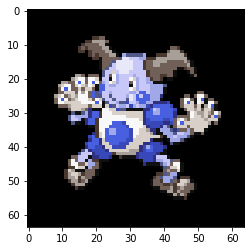

In [380]:
plt.imshow(unnormalize_tanh(X[0]))

Epoch [0/499]...
d_loss_real:0.209 d_loss_fake:1.297 d_acc_real:0.951 d_acc_fake:0.396
g_loss:0.396 g_acc:0.776
Epoch [1/499]...
d_loss_real:0.313 d_loss_fake:1.736 d_acc_real:0.831 d_acc_fake:0.188
g_loss:0.389 g_acc:0.799


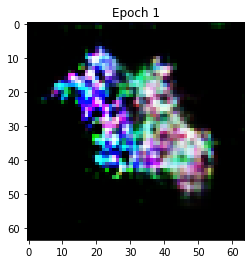

Epoch [2/499]...
d_loss_real:0.226 d_loss_fake:1.489 d_acc_real:0.917 d_acc_fake:0.323
g_loss:0.302 g_acc:0.930
Epoch [3/499]...
d_loss_real:0.369 d_loss_fake:1.407 d_acc_real:0.828 d_acc_fake:0.357
g_loss:0.288 g_acc:0.932
Epoch [4/499]...
d_loss_real:0.416 d_loss_fake:1.345 d_acc_real:0.747 d_acc_fake:0.331
g_loss:0.322 g_acc:0.857
Epoch [5/499]...
d_loss_real:0.163 d_loss_fake:1.499 d_acc_real:0.932 d_acc_fake:0.406
g_loss:0.195 g_acc:0.974
Epoch [6/499]...
d_loss_real:0.521 d_loss_fake:1.299 d_acc_real:0.844 d_acc_fake:0.393
g_loss:0.347 g_acc:0.840
Epoch [7/499]...
d_loss_real:0.476 d_loss_fake:1.581 d_acc_real:0.852 d_acc_fake:0.349
g_loss:0.225 g_acc:0.969
Epoch [8/499]...
d_loss_real:0.322 d_loss_fake:1.871 d_acc_real:0.857 d_acc_fake:0.216
g_loss:0.260 g_acc:0.953
Epoch [9/499]...
d_loss_real:0.420 d_loss_fake:1.683 d_acc_real:0.815 d_acc_fake:0.263
g_loss:0.333 g_acc:0.858


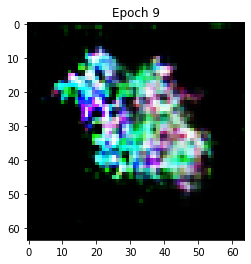

Epoch [10/499]...
d_loss_real:0.228 d_loss_fake:1.562 d_acc_real:0.964 d_acc_fake:0.224
g_loss:0.350 g_acc:0.840
Epoch [11/499]...
d_loss_real:0.384 d_loss_fake:1.497 d_acc_real:0.867 d_acc_fake:0.182
g_loss:0.304 g_acc:0.871
Epoch [12/499]...
d_loss_real:0.189 d_loss_fake:1.096 d_acc_real:0.969 d_acc_fake:0.505
g_loss:0.245 g_acc:0.927
Epoch [13/499]...
d_loss_real:0.293 d_loss_fake:1.826 d_acc_real:0.857 d_acc_fake:0.211
g_loss:0.328 g_acc:0.889
Epoch [14/499]...
d_loss_real:0.364 d_loss_fake:1.773 d_acc_real:0.831 d_acc_fake:0.312
g_loss:0.359 g_acc:0.829
Epoch [15/499]...
d_loss_real:0.227 d_loss_fake:1.227 d_acc_real:0.917 d_acc_fake:0.409
g_loss:0.288 g_acc:0.892
Epoch [16/499]...
d_loss_real:0.223 d_loss_fake:1.298 d_acc_real:0.891 d_acc_fake:0.398
g_loss:0.406 g_acc:0.764
Epoch [17/499]...
d_loss_real:0.249 d_loss_fake:1.832 d_acc_real:0.909 d_acc_fake:0.326
g_loss:0.229 g_acc:0.962
Epoch [18/499]...
d_loss_real:0.355 d_loss_fake:1.309 d_acc_real:0.841 d_acc_fake:0.339
g_loss:0

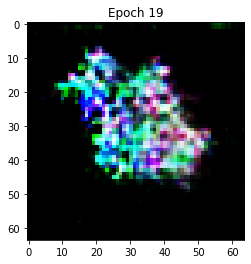

Epoch [20/499]...
d_loss_real:0.741 d_loss_fake:1.570 d_acc_real:0.724 d_acc_fake:0.289
g_loss:0.316 g_acc:0.887
Epoch [21/499]...
d_loss_real:0.193 d_loss_fake:2.063 d_acc_real:0.904 d_acc_fake:0.206
g_loss:0.329 g_acc:0.826
Epoch [22/499]...
d_loss_real:0.279 d_loss_fake:1.111 d_acc_real:0.901 d_acc_fake:0.440
g_loss:0.359 g_acc:0.814
Epoch [23/499]...
d_loss_real:0.309 d_loss_fake:1.894 d_acc_real:0.893 d_acc_fake:0.237
g_loss:0.320 g_acc:0.889
Epoch [24/499]...
d_loss_real:0.210 d_loss_fake:1.232 d_acc_real:0.966 d_acc_fake:0.487
g_loss:0.236 g_acc:0.914
Epoch [25/499]...
d_loss_real:0.594 d_loss_fake:1.526 d_acc_real:0.862 d_acc_fake:0.339
g_loss:0.346 g_acc:0.833
Epoch [26/499]...
d_loss_real:0.180 d_loss_fake:1.894 d_acc_real:0.979 d_acc_fake:0.237
g_loss:0.373 g_acc:0.858
Epoch [27/499]...
d_loss_real:0.394 d_loss_fake:1.267 d_acc_real:0.797 d_acc_fake:0.255
g_loss:0.435 g_acc:0.767
Epoch [28/499]...
d_loss_real:0.107 d_loss_fake:1.880 d_acc_real:0.984 d_acc_fake:0.398
g_loss:0

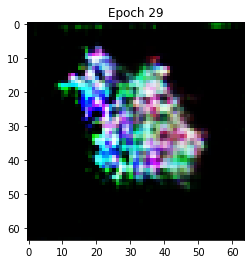

Epoch [30/499]...
d_loss_real:0.447 d_loss_fake:1.750 d_acc_real:0.818 d_acc_fake:0.086
g_loss:0.287 g_acc:0.902
Epoch [31/499]...
d_loss_real:0.393 d_loss_fake:1.648 d_acc_real:0.836 d_acc_fake:0.380
g_loss:0.348 g_acc:0.854
Epoch [32/499]...
d_loss_real:0.394 d_loss_fake:1.486 d_acc_real:0.763 d_acc_fake:0.378
g_loss:0.285 g_acc:0.875
Epoch [33/499]...
d_loss_real:0.304 d_loss_fake:1.497 d_acc_real:0.878 d_acc_fake:0.370
g_loss:0.211 g_acc:0.926
Epoch [34/499]...
d_loss_real:0.279 d_loss_fake:1.520 d_acc_real:0.888 d_acc_fake:0.406
g_loss:0.417 g_acc:0.766
Epoch [35/499]...
d_loss_real:0.234 d_loss_fake:1.915 d_acc_real:0.922 d_acc_fake:0.411
g_loss:0.444 g_acc:0.802
Epoch [36/499]...
d_loss_real:0.274 d_loss_fake:1.761 d_acc_real:0.885 d_acc_fake:0.286
g_loss:0.485 g_acc:0.688
Epoch [37/499]...
d_loss_real:0.148 d_loss_fake:1.893 d_acc_real:0.969 d_acc_fake:0.339
g_loss:0.388 g_acc:0.812
Epoch [38/499]...
d_loss_real:0.347 d_loss_fake:2.015 d_acc_real:0.839 d_acc_fake:0.320
g_loss:0

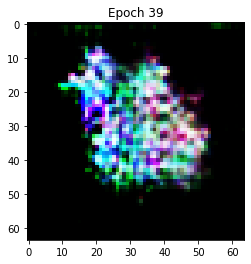

Epoch [40/499]...
d_loss_real:0.191 d_loss_fake:1.165 d_acc_real:0.961 d_acc_fake:0.461
g_loss:0.265 g_acc:0.897
Epoch [41/499]...
d_loss_real:0.322 d_loss_fake:1.846 d_acc_real:0.865 d_acc_fake:0.273
g_loss:0.335 g_acc:0.829
Epoch [42/499]...
d_loss_real:0.424 d_loss_fake:1.536 d_acc_real:0.820 d_acc_fake:0.240
g_loss:0.352 g_acc:0.826
Epoch [43/499]...
d_loss_real:0.260 d_loss_fake:1.601 d_acc_real:0.883 d_acc_fake:0.359
g_loss:0.458 g_acc:0.736
Epoch [44/499]...
d_loss_real:0.286 d_loss_fake:2.230 d_acc_real:0.909 d_acc_fake:0.156
g_loss:0.327 g_acc:0.867
Epoch [45/499]...
d_loss_real:0.311 d_loss_fake:1.481 d_acc_real:0.870 d_acc_fake:0.302
g_loss:0.322 g_acc:0.844
Epoch [46/499]...
d_loss_real:0.415 d_loss_fake:1.683 d_acc_real:0.823 d_acc_fake:0.266
g_loss:0.323 g_acc:0.862
Epoch [47/499]...
d_loss_real:0.286 d_loss_fake:1.584 d_acc_real:0.862 d_acc_fake:0.258
g_loss:0.287 g_acc:0.859
Epoch [48/499]...
d_loss_real:0.305 d_loss_fake:1.531 d_acc_real:0.891 d_acc_fake:0.237
g_loss:0

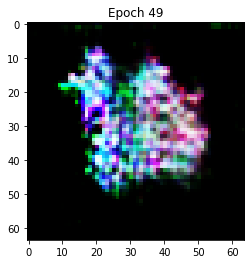

Epoch [50/499]...
d_loss_real:0.241 d_loss_fake:2.058 d_acc_real:0.875 d_acc_fake:0.276
g_loss:0.448 g_acc:0.757
Epoch [51/499]...
d_loss_real:0.186 d_loss_fake:1.630 d_acc_real:0.943 d_acc_fake:0.268
g_loss:0.389 g_acc:0.746
Epoch [52/499]...
d_loss_real:0.334 d_loss_fake:2.168 d_acc_real:0.867 d_acc_fake:0.279
g_loss:0.353 g_acc:0.827
Epoch [53/499]...
d_loss_real:0.335 d_loss_fake:1.719 d_acc_real:0.828 d_acc_fake:0.341
g_loss:0.314 g_acc:0.837
Epoch [54/499]...
d_loss_real:0.468 d_loss_fake:1.595 d_acc_real:0.768 d_acc_fake:0.292
g_loss:0.260 g_acc:0.930
Epoch [55/499]...
d_loss_real:0.270 d_loss_fake:1.739 d_acc_real:0.896 d_acc_fake:0.221
g_loss:0.412 g_acc:0.779
Epoch [56/499]...
d_loss_real:0.832 d_loss_fake:1.542 d_acc_real:0.727 d_acc_fake:0.417
g_loss:0.352 g_acc:0.876
Epoch [57/499]...
d_loss_real:0.141 d_loss_fake:2.393 d_acc_real:0.948 d_acc_fake:0.135
g_loss:0.338 g_acc:0.863
Epoch [58/499]...
d_loss_real:0.382 d_loss_fake:1.758 d_acc_real:0.849 d_acc_fake:0.357
g_loss:0

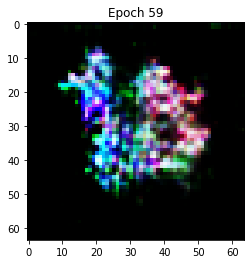

Epoch [60/499]...
d_loss_real:0.474 d_loss_fake:1.525 d_acc_real:0.760 d_acc_fake:0.398
g_loss:0.350 g_acc:0.802
Epoch [61/499]...
d_loss_real:0.217 d_loss_fake:1.664 d_acc_real:0.958 d_acc_fake:0.417
g_loss:0.351 g_acc:0.823
Epoch [62/499]...
d_loss_real:0.287 d_loss_fake:1.890 d_acc_real:0.898 d_acc_fake:0.294
g_loss:0.262 g_acc:0.949
Epoch [63/499]...
d_loss_real:0.376 d_loss_fake:1.601 d_acc_real:0.878 d_acc_fake:0.281
g_loss:0.293 g_acc:0.868
Epoch [64/499]...
d_loss_real:0.263 d_loss_fake:1.718 d_acc_real:0.888 d_acc_fake:0.326
g_loss:0.434 g_acc:0.762
Epoch [65/499]...
d_loss_real:0.431 d_loss_fake:1.824 d_acc_real:0.875 d_acc_fake:0.276
g_loss:0.292 g_acc:0.852
Epoch [66/499]...
d_loss_real:0.288 d_loss_fake:1.942 d_acc_real:0.904 d_acc_fake:0.224
g_loss:0.406 g_acc:0.760
Epoch [67/499]...
d_loss_real:0.487 d_loss_fake:2.051 d_acc_real:0.747 d_acc_fake:0.284
g_loss:0.475 g_acc:0.760
Epoch [68/499]...
d_loss_real:0.319 d_loss_fake:2.274 d_acc_real:0.831 d_acc_fake:0.221
g_loss:0

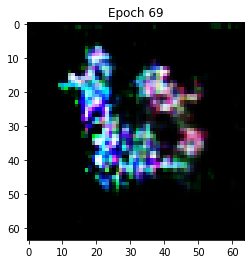

Epoch [70/499]...
d_loss_real:0.345 d_loss_fake:1.658 d_acc_real:0.833 d_acc_fake:0.219
g_loss:0.286 g_acc:0.892
Epoch [71/499]...
d_loss_real:0.370 d_loss_fake:1.806 d_acc_real:0.859 d_acc_fake:0.195
g_loss:0.271 g_acc:0.921
Epoch [72/499]...
d_loss_real:0.321 d_loss_fake:1.574 d_acc_real:0.893 d_acc_fake:0.333
g_loss:0.332 g_acc:0.876
Epoch [73/499]...
d_loss_real:0.541 d_loss_fake:1.541 d_acc_real:0.755 d_acc_fake:0.372
g_loss:0.234 g_acc:0.931
Epoch [74/499]...
d_loss_real:0.371 d_loss_fake:2.094 d_acc_real:0.797 d_acc_fake:0.169
g_loss:0.413 g_acc:0.796
Epoch [75/499]...
d_loss_real:0.487 d_loss_fake:1.617 d_acc_real:0.771 d_acc_fake:0.391
g_loss:0.260 g_acc:0.889
Epoch [76/499]...
d_loss_real:0.302 d_loss_fake:2.200 d_acc_real:0.859 d_acc_fake:0.216
g_loss:0.404 g_acc:0.775
Epoch [77/499]...
d_loss_real:0.390 d_loss_fake:2.050 d_acc_real:0.794 d_acc_fake:0.260
g_loss:0.343 g_acc:0.848
Epoch [78/499]...
d_loss_real:0.462 d_loss_fake:1.681 d_acc_real:0.857 d_acc_fake:0.302
g_loss:0

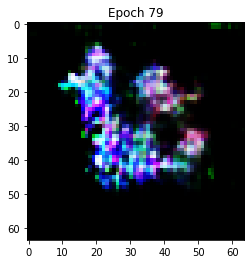

Epoch [80/499]...
d_loss_real:0.236 d_loss_fake:2.113 d_acc_real:0.883 d_acc_fake:0.258
g_loss:0.358 g_acc:0.822
Epoch [81/499]...
d_loss_real:0.398 d_loss_fake:1.804 d_acc_real:0.818 d_acc_fake:0.279
g_loss:0.382 g_acc:0.788
Epoch [82/499]...
d_loss_real:0.269 d_loss_fake:2.089 d_acc_real:0.940 d_acc_fake:0.365
g_loss:0.342 g_acc:0.826
Epoch [83/499]...
d_loss_real:0.288 d_loss_fake:1.969 d_acc_real:0.893 d_acc_fake:0.242
g_loss:0.342 g_acc:0.837
Epoch [84/499]...
d_loss_real:0.505 d_loss_fake:1.900 d_acc_real:0.828 d_acc_fake:0.266
g_loss:0.314 g_acc:0.861
Epoch [85/499]...
d_loss_real:0.583 d_loss_fake:1.600 d_acc_real:0.831 d_acc_fake:0.359
g_loss:0.327 g_acc:0.826
Epoch [86/499]...
d_loss_real:0.503 d_loss_fake:1.739 d_acc_real:0.781 d_acc_fake:0.375
g_loss:0.493 g_acc:0.740
Epoch [87/499]...
d_loss_real:0.172 d_loss_fake:2.271 d_acc_real:0.977 d_acc_fake:0.326
g_loss:0.281 g_acc:0.939
Epoch [88/499]...
d_loss_real:0.392 d_loss_fake:1.698 d_acc_real:0.831 d_acc_fake:0.271
g_loss:0

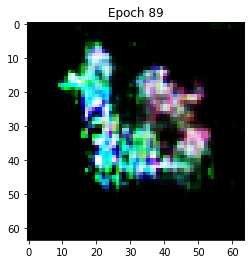

Epoch [90/499]...
d_loss_real:0.398 d_loss_fake:1.651 d_acc_real:0.763 d_acc_fake:0.445
g_loss:0.454 g_acc:0.805
Epoch [91/499]...
d_loss_real:0.148 d_loss_fake:2.506 d_acc_real:0.971 d_acc_fake:0.143
g_loss:0.474 g_acc:0.729
Epoch [92/499]...
d_loss_real:0.257 d_loss_fake:2.195 d_acc_real:0.924 d_acc_fake:0.260
g_loss:0.418 g_acc:0.734
Epoch [93/499]...
d_loss_real:0.261 d_loss_fake:1.741 d_acc_real:0.898 d_acc_fake:0.237
g_loss:0.438 g_acc:0.819
Epoch [94/499]...
d_loss_real:0.448 d_loss_fake:1.945 d_acc_real:0.794 d_acc_fake:0.310
g_loss:0.426 g_acc:0.746
Epoch [95/499]...
d_loss_real:0.321 d_loss_fake:2.217 d_acc_real:0.831 d_acc_fake:0.219
g_loss:0.269 g_acc:0.892
Epoch [96/499]...
d_loss_real:0.297 d_loss_fake:1.306 d_acc_real:0.904 d_acc_fake:0.503
g_loss:0.380 g_acc:0.775
Epoch [97/499]...
d_loss_real:0.321 d_loss_fake:2.061 d_acc_real:0.823 d_acc_fake:0.273
g_loss:0.358 g_acc:0.794
Epoch [98/499]...
d_loss_real:0.354 d_loss_fake:1.908 d_acc_real:0.836 d_acc_fake:0.206
g_loss:0

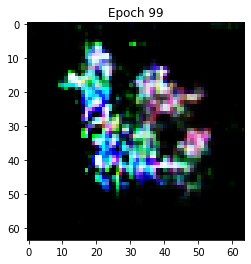

Epoch [100/499]...
d_loss_real:0.328 d_loss_fake:1.544 d_acc_real:0.818 d_acc_fake:0.260
g_loss:0.382 g_acc:0.802
Epoch [101/499]...
d_loss_real:0.237 d_loss_fake:1.362 d_acc_real:0.917 d_acc_fake:0.453
g_loss:0.245 g_acc:0.921
Epoch [102/499]...
d_loss_real:0.477 d_loss_fake:1.541 d_acc_real:0.771 d_acc_fake:0.333
g_loss:0.337 g_acc:0.828
Epoch [103/499]...
d_loss_real:0.236 d_loss_fake:2.277 d_acc_real:0.938 d_acc_fake:0.115
g_loss:0.332 g_acc:0.829
Epoch [104/499]...
d_loss_real:0.326 d_loss_fake:1.578 d_acc_real:0.919 d_acc_fake:0.432
g_loss:0.311 g_acc:0.892
Epoch [105/499]...
d_loss_real:0.433 d_loss_fake:1.974 d_acc_real:0.776 d_acc_fake:0.229
g_loss:0.297 g_acc:0.884
Epoch [106/499]...
d_loss_real:0.346 d_loss_fake:1.936 d_acc_real:0.865 d_acc_fake:0.273
g_loss:0.417 g_acc:0.764
Epoch [107/499]...
d_loss_real:0.360 d_loss_fake:1.632 d_acc_real:0.807 d_acc_fake:0.323
g_loss:0.390 g_acc:0.805
Epoch [108/499]...
d_loss_real:0.205 d_loss_fake:1.716 d_acc_real:0.966 d_acc_fake:0.346

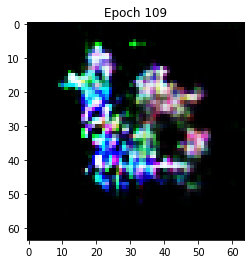

Epoch [110/499]...
d_loss_real:0.214 d_loss_fake:1.399 d_acc_real:0.971 d_acc_fake:0.346
g_loss:0.364 g_acc:0.819
Epoch [111/499]...
d_loss_real:0.439 d_loss_fake:1.940 d_acc_real:0.849 d_acc_fake:0.180
g_loss:0.368 g_acc:0.793
Epoch [112/499]...
d_loss_real:0.229 d_loss_fake:2.247 d_acc_real:0.958 d_acc_fake:0.240
g_loss:0.374 g_acc:0.781
Epoch [113/499]...
d_loss_real:0.228 d_loss_fake:0.964 d_acc_real:0.938 d_acc_fake:0.589
g_loss:0.399 g_acc:0.820
Epoch [114/499]...
d_loss_real:0.165 d_loss_fake:1.815 d_acc_real:0.982 d_acc_fake:0.367
g_loss:0.415 g_acc:0.788
Epoch [115/499]...
d_loss_real:0.308 d_loss_fake:2.206 d_acc_real:0.911 d_acc_fake:0.143
g_loss:0.328 g_acc:0.852
Epoch [116/499]...
d_loss_real:0.359 d_loss_fake:1.803 d_acc_real:0.841 d_acc_fake:0.180
g_loss:0.331 g_acc:0.836
Epoch [117/499]...
d_loss_real:0.479 d_loss_fake:1.756 d_acc_real:0.659 d_acc_fake:0.250
g_loss:0.314 g_acc:0.882
Epoch [118/499]...
d_loss_real:0.263 d_loss_fake:1.691 d_acc_real:0.885 d_acc_fake:0.281

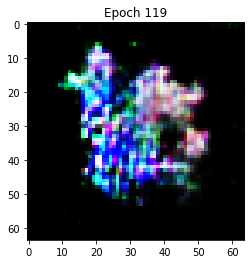

Epoch [120/499]...
d_loss_real:0.182 d_loss_fake:2.366 d_acc_real:0.953 d_acc_fake:0.219
g_loss:0.301 g_acc:0.892
Epoch [121/499]...
d_loss_real:0.747 d_loss_fake:1.506 d_acc_real:0.727 d_acc_fake:0.372
g_loss:0.270 g_acc:0.889
Epoch [122/499]...
d_loss_real:0.406 d_loss_fake:2.230 d_acc_real:0.865 d_acc_fake:0.164
g_loss:0.294 g_acc:0.923
Epoch [123/499]...
d_loss_real:0.322 d_loss_fake:1.712 d_acc_real:0.875 d_acc_fake:0.247
g_loss:0.388 g_acc:0.789
Epoch [124/499]...
d_loss_real:0.343 d_loss_fake:1.702 d_acc_real:0.906 d_acc_fake:0.258
g_loss:0.281 g_acc:0.932
Epoch [125/499]...
d_loss_real:0.512 d_loss_fake:1.912 d_acc_real:0.784 d_acc_fake:0.362
g_loss:0.426 g_acc:0.789
Epoch [126/499]...
d_loss_real:0.466 d_loss_fake:1.660 d_acc_real:0.755 d_acc_fake:0.362
g_loss:0.311 g_acc:0.814
Epoch [127/499]...
d_loss_real:0.229 d_loss_fake:2.332 d_acc_real:0.917 d_acc_fake:0.237
g_loss:0.422 g_acc:0.758
Epoch [128/499]...
d_loss_real:0.343 d_loss_fake:1.888 d_acc_real:0.831 d_acc_fake:0.341

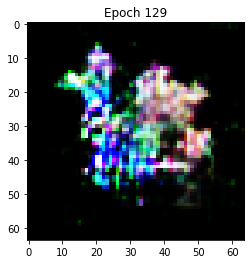

Epoch [130/499]...
d_loss_real:0.289 d_loss_fake:1.885 d_acc_real:0.885 d_acc_fake:0.336
g_loss:0.333 g_acc:0.811
Epoch [131/499]...
d_loss_real:0.663 d_loss_fake:1.823 d_acc_real:0.820 d_acc_fake:0.266
g_loss:0.359 g_acc:0.815
Epoch [132/499]...
d_loss_real:0.266 d_loss_fake:2.387 d_acc_real:0.883 d_acc_fake:0.112
g_loss:0.377 g_acc:0.807
Epoch [133/499]...
d_loss_real:0.328 d_loss_fake:1.829 d_acc_real:0.872 d_acc_fake:0.294
g_loss:0.370 g_acc:0.827
Epoch [134/499]...
d_loss_real:0.338 d_loss_fake:1.703 d_acc_real:0.870 d_acc_fake:0.312
g_loss:0.297 g_acc:0.865
Epoch [135/499]...
d_loss_real:0.326 d_loss_fake:2.010 d_acc_real:0.865 d_acc_fake:0.229
g_loss:0.323 g_acc:0.862
Epoch [136/499]...
d_loss_real:0.481 d_loss_fake:1.619 d_acc_real:0.690 d_acc_fake:0.284
g_loss:0.311 g_acc:0.888
Epoch [137/499]...
d_loss_real:0.421 d_loss_fake:1.887 d_acc_real:0.799 d_acc_fake:0.237
g_loss:0.290 g_acc:0.878
Epoch [138/499]...
d_loss_real:0.256 d_loss_fake:1.665 d_acc_real:0.958 d_acc_fake:0.260

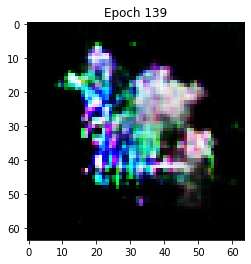

Epoch [140/499]...
d_loss_real:0.357 d_loss_fake:2.734 d_acc_real:0.826 d_acc_fake:0.094
g_loss:0.327 g_acc:0.832
Epoch [141/499]...
d_loss_real:0.359 d_loss_fake:1.303 d_acc_real:0.891 d_acc_fake:0.518
g_loss:0.617 g_acc:0.736
Epoch [142/499]...
d_loss_real:0.171 d_loss_fake:2.227 d_acc_real:0.971 d_acc_fake:0.177
g_loss:0.455 g_acc:0.712
Epoch [143/499]...
d_loss_real:0.391 d_loss_fake:2.092 d_acc_real:0.865 d_acc_fake:0.294
g_loss:0.384 g_acc:0.837
Epoch [144/499]...
d_loss_real:0.323 d_loss_fake:2.057 d_acc_real:0.849 d_acc_fake:0.221
g_loss:0.415 g_acc:0.779
Epoch [145/499]...
d_loss_real:0.420 d_loss_fake:2.088 d_acc_real:0.742 d_acc_fake:0.253
g_loss:0.447 g_acc:0.758
Epoch [146/499]...
d_loss_real:0.327 d_loss_fake:1.995 d_acc_real:0.870 d_acc_fake:0.247
g_loss:0.344 g_acc:0.867
Epoch [147/499]...
d_loss_real:0.291 d_loss_fake:1.565 d_acc_real:0.885 d_acc_fake:0.211
g_loss:0.344 g_acc:0.833
Epoch [148/499]...
d_loss_real:0.290 d_loss_fake:1.383 d_acc_real:0.893 d_acc_fake:0.328

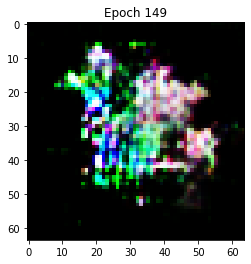

Epoch [150/499]...
d_loss_real:0.229 d_loss_fake:1.368 d_acc_real:0.930 d_acc_fake:0.385
g_loss:0.461 g_acc:0.781
Epoch [151/499]...
d_loss_real:0.282 d_loss_fake:2.392 d_acc_real:0.909 d_acc_fake:0.109
g_loss:0.291 g_acc:0.941
Epoch [152/499]...
d_loss_real:0.336 d_loss_fake:1.440 d_acc_real:0.875 d_acc_fake:0.281
g_loss:0.308 g_acc:0.926
Epoch [153/499]...
d_loss_real:0.366 d_loss_fake:1.578 d_acc_real:0.828 d_acc_fake:0.263
g_loss:0.333 g_acc:0.895
Epoch [154/499]...
d_loss_real:0.499 d_loss_fake:1.661 d_acc_real:0.812 d_acc_fake:0.292
g_loss:0.388 g_acc:0.790
Epoch [155/499]...
d_loss_real:0.250 d_loss_fake:1.846 d_acc_real:0.904 d_acc_fake:0.237
g_loss:0.380 g_acc:0.839
Epoch [156/499]...
d_loss_real:0.339 d_loss_fake:1.773 d_acc_real:0.859 d_acc_fake:0.206
g_loss:0.355 g_acc:0.824
Epoch [157/499]...
d_loss_real:0.296 d_loss_fake:1.313 d_acc_real:0.883 d_acc_fake:0.445
g_loss:0.295 g_acc:0.878
Epoch [158/499]...
d_loss_real:0.210 d_loss_fake:1.723 d_acc_real:0.938 d_acc_fake:0.182

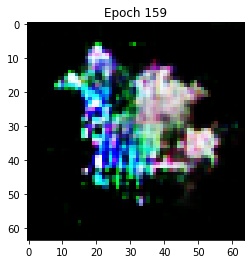

Epoch [160/499]...
d_loss_real:0.183 d_loss_fake:0.991 d_acc_real:0.974 d_acc_fake:0.549
g_loss:0.261 g_acc:0.892
Epoch [161/499]...
d_loss_real:0.401 d_loss_fake:1.925 d_acc_real:0.758 d_acc_fake:0.260
g_loss:0.496 g_acc:0.710
Epoch [162/499]...
d_loss_real:0.329 d_loss_fake:1.934 d_acc_real:0.880 d_acc_fake:0.260
g_loss:0.361 g_acc:0.816
Epoch [163/499]...
d_loss_real:0.406 d_loss_fake:1.931 d_acc_real:0.820 d_acc_fake:0.214
g_loss:0.385 g_acc:0.789
Epoch [164/499]...
d_loss_real:0.600 d_loss_fake:1.239 d_acc_real:0.820 d_acc_fake:0.544
g_loss:0.461 g_acc:0.763
Epoch [165/499]...
d_loss_real:0.134 d_loss_fake:1.607 d_acc_real:0.966 d_acc_fake:0.299
g_loss:0.351 g_acc:0.792
Epoch [166/499]...
d_loss_real:0.361 d_loss_fake:2.890 d_acc_real:0.812 d_acc_fake:0.138
g_loss:0.388 g_acc:0.826
Epoch [167/499]...
d_loss_real:0.403 d_loss_fake:1.517 d_acc_real:0.784 d_acc_fake:0.393
g_loss:0.561 g_acc:0.792
Epoch [168/499]...
d_loss_real:0.340 d_loss_fake:1.912 d_acc_real:0.875 d_acc_fake:0.326

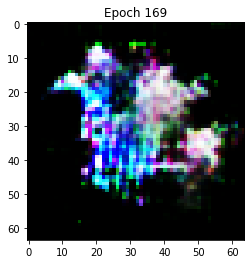

Epoch [170/499]...
d_loss_real:0.226 d_loss_fake:0.874 d_acc_real:0.935 d_acc_fake:0.529
g_loss:0.380 g_acc:0.833
Epoch [171/499]...
d_loss_real:0.258 d_loss_fake:1.899 d_acc_real:0.888 d_acc_fake:0.289
g_loss:0.458 g_acc:0.759
Epoch [172/499]...
d_loss_real:0.326 d_loss_fake:2.268 d_acc_real:0.826 d_acc_fake:0.203
g_loss:0.358 g_acc:0.840
Epoch [173/499]...
d_loss_real:0.430 d_loss_fake:1.204 d_acc_real:0.862 d_acc_fake:0.427
g_loss:0.334 g_acc:0.844
Epoch [174/499]...
d_loss_real:0.243 d_loss_fake:2.309 d_acc_real:0.922 d_acc_fake:0.094
g_loss:0.271 g_acc:0.936
Epoch [175/499]...
d_loss_real:0.388 d_loss_fake:1.433 d_acc_real:0.815 d_acc_fake:0.312
g_loss:0.326 g_acc:0.872
Epoch [176/499]...
d_loss_real:0.961 d_loss_fake:1.483 d_acc_real:0.794 d_acc_fake:0.401
g_loss:0.364 g_acc:0.852
Epoch [177/499]...
d_loss_real:0.288 d_loss_fake:2.313 d_acc_real:0.914 d_acc_fake:0.161
g_loss:0.444 g_acc:0.754
Epoch [178/499]...
d_loss_real:0.412 d_loss_fake:1.837 d_acc_real:0.776 d_acc_fake:0.237

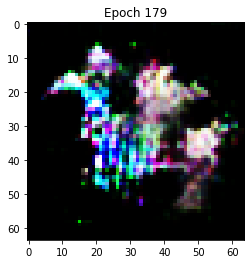

Epoch [180/499]...
d_loss_real:0.349 d_loss_fake:1.984 d_acc_real:0.872 d_acc_fake:0.242
g_loss:0.354 g_acc:0.816
Epoch [181/499]...
d_loss_real:0.303 d_loss_fake:1.645 d_acc_real:0.880 d_acc_fake:0.255
g_loss:0.325 g_acc:0.895
Epoch [182/499]...
d_loss_real:0.404 d_loss_fake:1.562 d_acc_real:0.820 d_acc_fake:0.328
g_loss:0.362 g_acc:0.829
Epoch [183/499]...
d_loss_real:0.210 d_loss_fake:1.611 d_acc_real:0.974 d_acc_fake:0.229
g_loss:0.383 g_acc:0.775
Epoch [184/499]...
d_loss_real:0.415 d_loss_fake:1.430 d_acc_real:0.823 d_acc_fake:0.359
g_loss:0.322 g_acc:0.835
Epoch [185/499]...
d_loss_real:0.373 d_loss_fake:1.875 d_acc_real:0.773 d_acc_fake:0.253
g_loss:0.328 g_acc:0.858
Epoch [186/499]...
d_loss_real:0.275 d_loss_fake:1.336 d_acc_real:0.909 d_acc_fake:0.547
g_loss:0.267 g_acc:0.921
Epoch [187/499]...
d_loss_real:0.463 d_loss_fake:1.920 d_acc_real:0.758 d_acc_fake:0.109
g_loss:0.277 g_acc:0.939
Epoch [188/499]...
d_loss_real:0.449 d_loss_fake:1.565 d_acc_real:0.826 d_acc_fake:0.271

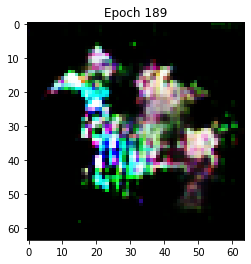

Epoch [190/499]...
d_loss_real:0.254 d_loss_fake:1.627 d_acc_real:0.948 d_acc_fake:0.365
g_loss:0.473 g_acc:0.745
Epoch [191/499]...
d_loss_real:0.598 d_loss_fake:1.909 d_acc_real:0.849 d_acc_fake:0.339
g_loss:0.337 g_acc:0.872
Epoch [192/499]...
d_loss_real:0.211 d_loss_fake:2.180 d_acc_real:0.961 d_acc_fake:0.073
g_loss:0.307 g_acc:0.878
Epoch [193/499]...
d_loss_real:0.359 d_loss_fake:1.605 d_acc_real:0.846 d_acc_fake:0.391
g_loss:0.386 g_acc:0.867
Epoch [194/499]...
d_loss_real:0.337 d_loss_fake:1.692 d_acc_real:0.841 d_acc_fake:0.289
g_loss:0.359 g_acc:0.829
Epoch [195/499]...
d_loss_real:0.434 d_loss_fake:1.587 d_acc_real:0.828 d_acc_fake:0.245
g_loss:0.342 g_acc:0.809
Epoch [196/499]...
d_loss_real:0.281 d_loss_fake:1.880 d_acc_real:0.932 d_acc_fake:0.208
g_loss:0.313 g_acc:0.896
Epoch [197/499]...
d_loss_real:0.370 d_loss_fake:1.247 d_acc_real:0.841 d_acc_fake:0.456
g_loss:0.491 g_acc:0.790
Epoch [198/499]...
d_loss_real:0.331 d_loss_fake:1.795 d_acc_real:0.872 d_acc_fake:0.315

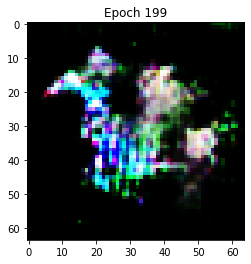

Epoch [200/499]...
d_loss_real:0.323 d_loss_fake:1.789 d_acc_real:0.919 d_acc_fake:0.224
g_loss:0.380 g_acc:0.818
Epoch [201/499]...
d_loss_real:0.326 d_loss_fake:1.603 d_acc_real:0.938 d_acc_fake:0.240
g_loss:0.266 g_acc:0.960
Epoch [202/499]...
d_loss_real:0.511 d_loss_fake:1.296 d_acc_real:0.849 d_acc_fake:0.471
g_loss:0.284 g_acc:0.897
Epoch [203/499]...
d_loss_real:0.216 d_loss_fake:1.810 d_acc_real:0.974 d_acc_fake:0.128
g_loss:0.306 g_acc:0.901
Epoch [204/499]...
d_loss_real:0.361 d_loss_fake:1.372 d_acc_real:0.844 d_acc_fake:0.318
g_loss:0.376 g_acc:0.811
Epoch [205/499]...
d_loss_real:0.289 d_loss_fake:1.587 d_acc_real:0.901 d_acc_fake:0.258
g_loss:0.262 g_acc:0.958
Epoch [206/499]...
d_loss_real:0.746 d_loss_fake:1.588 d_acc_real:0.703 d_acc_fake:0.284
g_loss:0.237 g_acc:0.962
Epoch [207/499]...
d_loss_real:0.310 d_loss_fake:1.934 d_acc_real:0.878 d_acc_fake:0.206
g_loss:0.389 g_acc:0.810
Epoch [208/499]...
d_loss_real:0.327 d_loss_fake:1.632 d_acc_real:0.857 d_acc_fake:0.339

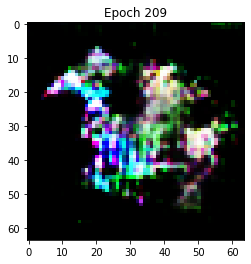

Epoch [210/499]...
d_loss_real:0.277 d_loss_fake:1.737 d_acc_real:0.893 d_acc_fake:0.214
g_loss:0.334 g_acc:0.861
Epoch [211/499]...
d_loss_real:0.317 d_loss_fake:1.440 d_acc_real:0.917 d_acc_fake:0.352
g_loss:0.373 g_acc:0.835
Epoch [212/499]...
d_loss_real:0.438 d_loss_fake:1.605 d_acc_real:0.826 d_acc_fake:0.234
g_loss:0.325 g_acc:0.875
Epoch [213/499]...
d_loss_real:0.383 d_loss_fake:1.441 d_acc_real:0.839 d_acc_fake:0.326
g_loss:0.424 g_acc:0.798
Epoch [214/499]...
d_loss_real:0.191 d_loss_fake:1.501 d_acc_real:0.943 d_acc_fake:0.378
g_loss:0.341 g_acc:0.798
Epoch [215/499]...
d_loss_real:0.273 d_loss_fake:2.339 d_acc_real:0.938 d_acc_fake:0.081
g_loss:0.317 g_acc:0.892
Epoch [216/499]...
d_loss_real:0.465 d_loss_fake:1.566 d_acc_real:0.878 d_acc_fake:0.289
g_loss:0.370 g_acc:0.809
Epoch [217/499]...
d_loss_real:0.284 d_loss_fake:1.472 d_acc_real:0.883 d_acc_fake:0.305
g_loss:0.287 g_acc:0.878
Epoch [218/499]...
d_loss_real:0.330 d_loss_fake:1.785 d_acc_real:0.870 d_acc_fake:0.294

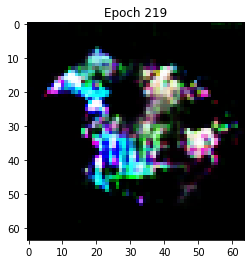

Epoch [220/499]...
d_loss_real:0.294 d_loss_fake:1.730 d_acc_real:0.922 d_acc_fake:0.141
g_loss:0.287 g_acc:0.951
Epoch [221/499]...
d_loss_real:0.299 d_loss_fake:1.518 d_acc_real:0.891 d_acc_fake:0.273
g_loss:0.338 g_acc:0.893
Epoch [222/499]...
d_loss_real:0.404 d_loss_fake:1.534 d_acc_real:0.781 d_acc_fake:0.385
g_loss:0.379 g_acc:0.799
Epoch [223/499]...
d_loss_real:0.305 d_loss_fake:1.780 d_acc_real:0.940 d_acc_fake:0.227
g_loss:0.281 g_acc:0.943
Epoch [224/499]...
d_loss_real:0.325 d_loss_fake:1.583 d_acc_real:0.867 d_acc_fake:0.323
g_loss:0.411 g_acc:0.854
Epoch [225/499]...
d_loss_real:0.614 d_loss_fake:1.874 d_acc_real:0.768 d_acc_fake:0.190
g_loss:0.351 g_acc:0.855
Epoch [226/499]...
d_loss_real:0.267 d_loss_fake:1.978 d_acc_real:0.906 d_acc_fake:0.180
g_loss:0.338 g_acc:0.902
Epoch [227/499]...
d_loss_real:0.431 d_loss_fake:1.388 d_acc_real:0.737 d_acc_fake:0.307
g_loss:0.289 g_acc:0.927
Epoch [228/499]...
d_loss_real:0.370 d_loss_fake:1.757 d_acc_real:0.833 d_acc_fake:0.086

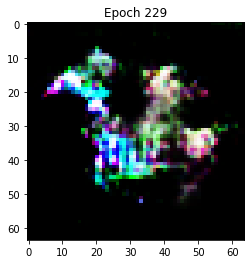

Epoch [230/499]...
d_loss_real:0.170 d_loss_fake:1.956 d_acc_real:0.982 d_acc_fake:0.169
g_loss:0.345 g_acc:0.839
Epoch [231/499]...
d_loss_real:0.257 d_loss_fake:1.813 d_acc_real:0.953 d_acc_fake:0.247
g_loss:0.339 g_acc:0.898
Epoch [232/499]...
d_loss_real:0.501 d_loss_fake:1.508 d_acc_real:0.727 d_acc_fake:0.417
g_loss:0.388 g_acc:0.823
Epoch [233/499]...
d_loss_real:0.336 d_loss_fake:1.833 d_acc_real:0.878 d_acc_fake:0.273
g_loss:0.372 g_acc:0.812
Epoch [234/499]...
d_loss_real:0.196 d_loss_fake:1.635 d_acc_real:0.974 d_acc_fake:0.237
g_loss:0.383 g_acc:0.806
Epoch [235/499]...
d_loss_real:0.461 d_loss_fake:1.745 d_acc_real:0.812 d_acc_fake:0.260
g_loss:0.302 g_acc:0.891
Epoch [236/499]...
d_loss_real:0.319 d_loss_fake:1.702 d_acc_real:0.870 d_acc_fake:0.240
g_loss:0.352 g_acc:0.844
Epoch [237/499]...
d_loss_real:0.381 d_loss_fake:1.535 d_acc_real:0.844 d_acc_fake:0.211
g_loss:0.332 g_acc:0.854
Epoch [238/499]...
d_loss_real:0.373 d_loss_fake:1.466 d_acc_real:0.844 d_acc_fake:0.255

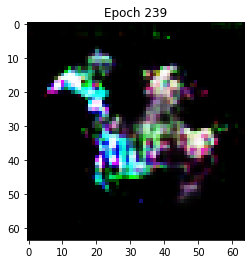

Epoch [240/499]...
d_loss_real:0.164 d_loss_fake:1.734 d_acc_real:0.974 d_acc_fake:0.216
g_loss:0.479 g_acc:0.734
Epoch [241/499]...
d_loss_real:0.284 d_loss_fake:1.706 d_acc_real:0.922 d_acc_fake:0.268
g_loss:0.329 g_acc:0.896
Epoch [242/499]...
d_loss_real:0.474 d_loss_fake:1.069 d_acc_real:0.805 d_acc_fake:0.573
g_loss:0.277 g_acc:0.898
Epoch [243/499]...
d_loss_real:0.222 d_loss_fake:2.047 d_acc_real:0.917 d_acc_fake:0.201
g_loss:0.270 g_acc:0.965
Epoch [244/499]...
d_loss_real:0.426 d_loss_fake:1.362 d_acc_real:0.872 d_acc_fake:0.424
g_loss:0.336 g_acc:0.875
Epoch [245/499]...
d_loss_real:0.435 d_loss_fake:1.766 d_acc_real:0.792 d_acc_fake:0.323
g_loss:0.344 g_acc:0.858
Epoch [246/499]...
d_loss_real:0.279 d_loss_fake:1.817 d_acc_real:0.880 d_acc_fake:0.250
g_loss:0.355 g_acc:0.883
Epoch [247/499]...
d_loss_real:0.341 d_loss_fake:1.510 d_acc_real:0.888 d_acc_fake:0.268
g_loss:0.287 g_acc:0.928
Epoch [248/499]...
d_loss_real:0.376 d_loss_fake:1.480 d_acc_real:0.875 d_acc_fake:0.299

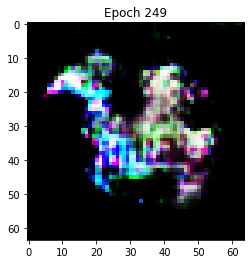

Epoch [250/499]...
d_loss_real:0.284 d_loss_fake:1.482 d_acc_real:0.935 d_acc_fake:0.227
g_loss:0.428 g_acc:0.757
Epoch [251/499]...
d_loss_real:0.265 d_loss_fake:2.195 d_acc_real:0.891 d_acc_fake:0.104
g_loss:0.392 g_acc:0.855
Epoch [252/499]...
d_loss_real:0.312 d_loss_fake:1.672 d_acc_real:0.883 d_acc_fake:0.255
g_loss:0.386 g_acc:0.823
Epoch [253/499]...
d_loss_real:0.355 d_loss_fake:1.501 d_acc_real:0.870 d_acc_fake:0.242
g_loss:0.364 g_acc:0.840
Epoch [254/499]...
d_loss_real:0.394 d_loss_fake:1.486 d_acc_real:0.888 d_acc_fake:0.255
g_loss:0.366 g_acc:0.816
Epoch [255/499]...
d_loss_real:0.249 d_loss_fake:1.431 d_acc_real:0.909 d_acc_fake:0.388
g_loss:0.342 g_acc:0.846
Epoch [256/499]...
d_loss_real:0.503 d_loss_fake:1.746 d_acc_real:0.799 d_acc_fake:0.221
g_loss:0.291 g_acc:0.947
Epoch [257/499]...
d_loss_real:0.225 d_loss_fake:1.570 d_acc_real:0.935 d_acc_fake:0.318
g_loss:0.350 g_acc:0.853
Epoch [258/499]...
d_loss_real:0.837 d_loss_fake:1.531 d_acc_real:0.682 d_acc_fake:0.424

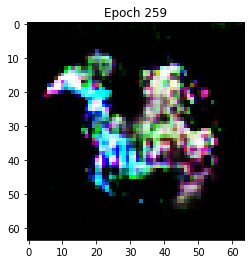

Epoch [260/499]...
d_loss_real:0.313 d_loss_fake:1.633 d_acc_real:0.867 d_acc_fake:0.273
g_loss:0.383 g_acc:0.842
Epoch [261/499]...
d_loss_real:0.315 d_loss_fake:1.475 d_acc_real:0.854 d_acc_fake:0.263
g_loss:0.303 g_acc:0.900
Epoch [262/499]...
d_loss_real:0.362 d_loss_fake:1.579 d_acc_real:0.797 d_acc_fake:0.224
g_loss:0.331 g_acc:0.857
Epoch [263/499]...
d_loss_real:0.275 d_loss_fake:1.422 d_acc_real:0.911 d_acc_fake:0.318
g_loss:0.307 g_acc:0.866
Epoch [264/499]...
d_loss_real:0.452 d_loss_fake:1.817 d_acc_real:0.760 d_acc_fake:0.198
g_loss:0.321 g_acc:0.896
Epoch [265/499]...
d_loss_real:0.316 d_loss_fake:1.789 d_acc_real:0.938 d_acc_fake:0.255
g_loss:0.289 g_acc:0.927
Epoch [266/499]...
d_loss_real:0.314 d_loss_fake:1.093 d_acc_real:0.870 d_acc_fake:0.484
g_loss:0.298 g_acc:0.868
Epoch [267/499]...
d_loss_real:0.263 d_loss_fake:1.324 d_acc_real:0.911 d_acc_fake:0.409
g_loss:0.275 g_acc:0.870
Epoch [268/499]...
d_loss_real:0.283 d_loss_fake:1.434 d_acc_real:0.893 d_acc_fake:0.372

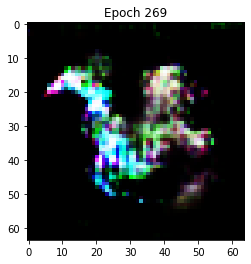

Epoch [270/499]...
d_loss_real:0.132 d_loss_fake:1.774 d_acc_real:0.977 d_acc_fake:0.224
g_loss:0.290 g_acc:0.913
Epoch [271/499]...
d_loss_real:0.387 d_loss_fake:1.436 d_acc_real:0.844 d_acc_fake:0.310
g_loss:0.304 g_acc:0.940
Epoch [272/499]...
d_loss_real:0.362 d_loss_fake:1.378 d_acc_real:0.849 d_acc_fake:0.328
g_loss:0.239 g_acc:0.964
Epoch [273/499]...
d_loss_real:0.673 d_loss_fake:1.560 d_acc_real:0.693 d_acc_fake:0.271
g_loss:0.304 g_acc:0.928
Epoch [274/499]...
d_loss_real:0.270 d_loss_fake:1.573 d_acc_real:0.964 d_acc_fake:0.344
g_loss:0.320 g_acc:0.863
Epoch [275/499]...
d_loss_real:0.152 d_loss_fake:1.191 d_acc_real:0.987 d_acc_fake:0.440
g_loss:0.297 g_acc:0.862
Epoch [276/499]...
d_loss_real:0.599 d_loss_fake:1.660 d_acc_real:0.805 d_acc_fake:0.307
g_loss:0.396 g_acc:0.811
Epoch [277/499]...
d_loss_real:0.295 d_loss_fake:1.687 d_acc_real:0.891 d_acc_fake:0.188
g_loss:0.305 g_acc:0.868
Epoch [278/499]...
d_loss_real:0.406 d_loss_fake:1.851 d_acc_real:0.878 d_acc_fake:0.216

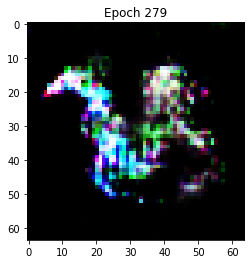

Epoch [280/499]...
d_loss_real:0.436 d_loss_fake:1.689 d_acc_real:0.870 d_acc_fake:0.323
g_loss:0.357 g_acc:0.849
Epoch [281/499]...
d_loss_real:0.246 d_loss_fake:1.938 d_acc_real:0.898 d_acc_fake:0.227
g_loss:0.305 g_acc:0.897
Epoch [282/499]...
d_loss_real:0.367 d_loss_fake:1.625 d_acc_real:0.833 d_acc_fake:0.302
g_loss:0.325 g_acc:0.849
Epoch [283/499]...
d_loss_real:0.281 d_loss_fake:1.501 d_acc_real:0.893 d_acc_fake:0.359
g_loss:0.384 g_acc:0.781
Epoch [284/499]...
d_loss_real:0.236 d_loss_fake:1.674 d_acc_real:0.956 d_acc_fake:0.318
g_loss:0.259 g_acc:0.956
Epoch [285/499]...
d_loss_real:0.378 d_loss_fake:1.333 d_acc_real:0.870 d_acc_fake:0.240
g_loss:0.292 g_acc:0.931
Epoch [286/499]...
d_loss_real:0.533 d_loss_fake:1.369 d_acc_real:0.771 d_acc_fake:0.404
g_loss:0.313 g_acc:0.846
Epoch [287/499]...
d_loss_real:0.271 d_loss_fake:1.174 d_acc_real:0.896 d_acc_fake:0.552
g_loss:0.290 g_acc:0.842
Epoch [288/499]...
d_loss_real:0.231 d_loss_fake:2.002 d_acc_real:0.898 d_acc_fake:0.271

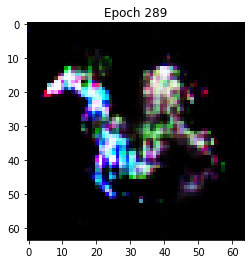

Epoch [290/499]...
d_loss_real:0.321 d_loss_fake:1.342 d_acc_real:0.857 d_acc_fake:0.346
g_loss:0.365 g_acc:0.806
Epoch [291/499]...
d_loss_real:0.268 d_loss_fake:1.390 d_acc_real:0.914 d_acc_fake:0.349
g_loss:0.308 g_acc:0.858
Epoch [292/499]...
d_loss_real:0.272 d_loss_fake:1.718 d_acc_real:0.911 d_acc_fake:0.312
g_loss:0.291 g_acc:0.863
Epoch [293/499]...
d_loss_real:0.411 d_loss_fake:1.701 d_acc_real:0.823 d_acc_fake:0.250
g_loss:0.332 g_acc:0.905
Epoch [294/499]...
d_loss_real:0.374 d_loss_fake:1.762 d_acc_real:0.799 d_acc_fake:0.404
g_loss:0.317 g_acc:0.910
Epoch [295/499]...
d_loss_real:0.338 d_loss_fake:1.690 d_acc_real:0.820 d_acc_fake:0.216
g_loss:0.396 g_acc:0.822
Epoch [296/499]...
d_loss_real:0.266 d_loss_fake:1.595 d_acc_real:0.896 d_acc_fake:0.214
g_loss:0.331 g_acc:0.827
Epoch [297/499]...
d_loss_real:0.217 d_loss_fake:1.483 d_acc_real:0.964 d_acc_fake:0.294
g_loss:0.375 g_acc:0.792
Epoch [298/499]...
d_loss_real:0.581 d_loss_fake:1.443 d_acc_real:0.719 d_acc_fake:0.453

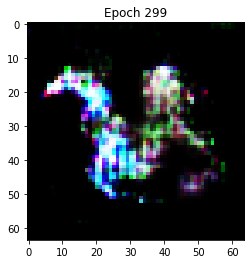

Epoch [300/499]...
d_loss_real:0.671 d_loss_fake:1.666 d_acc_real:0.641 d_acc_fake:0.323
g_loss:0.459 g_acc:0.839
Epoch [301/499]...
d_loss_real:0.275 d_loss_fake:1.848 d_acc_real:0.901 d_acc_fake:0.190
g_loss:0.231 g_acc:0.962
Epoch [302/499]...
d_loss_real:0.394 d_loss_fake:1.639 d_acc_real:0.839 d_acc_fake:0.312
g_loss:0.388 g_acc:0.801
Epoch [303/499]...
d_loss_real:0.269 d_loss_fake:1.549 d_acc_real:0.924 d_acc_fake:0.305
g_loss:0.338 g_acc:0.807
Epoch [304/499]...
d_loss_real:0.577 d_loss_fake:1.878 d_acc_real:0.792 d_acc_fake:0.219
g_loss:0.350 g_acc:0.837
Epoch [305/499]...
d_loss_real:0.242 d_loss_fake:1.730 d_acc_real:0.935 d_acc_fake:0.195
g_loss:0.346 g_acc:0.812
Epoch [306/499]...
d_loss_real:0.287 d_loss_fake:1.334 d_acc_real:0.919 d_acc_fake:0.331
g_loss:0.321 g_acc:0.897
Epoch [307/499]...
d_loss_real:0.377 d_loss_fake:1.753 d_acc_real:0.799 d_acc_fake:0.294
g_loss:0.398 g_acc:0.796
Epoch [308/499]...
d_loss_real:0.299 d_loss_fake:1.653 d_acc_real:0.885 d_acc_fake:0.190

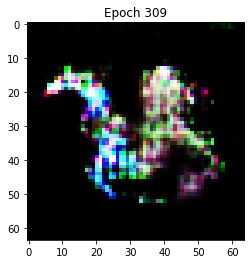

Epoch [310/499]...
d_loss_real:0.376 d_loss_fake:1.456 d_acc_real:0.833 d_acc_fake:0.221
g_loss:0.282 g_acc:0.904
Epoch [311/499]...
d_loss_real:0.294 d_loss_fake:1.535 d_acc_real:0.901 d_acc_fake:0.422
g_loss:0.346 g_acc:0.870
Epoch [312/499]...
d_loss_real:0.301 d_loss_fake:1.634 d_acc_real:0.875 d_acc_fake:0.263
g_loss:0.305 g_acc:0.911
Epoch [313/499]...
d_loss_real:0.291 d_loss_fake:1.140 d_acc_real:0.922 d_acc_fake:0.482
g_loss:0.253 g_acc:0.945
Epoch [314/499]...
d_loss_real:0.234 d_loss_fake:1.447 d_acc_real:0.911 d_acc_fake:0.404
g_loss:0.255 g_acc:0.960
Epoch [315/499]...
d_loss_real:0.453 d_loss_fake:1.423 d_acc_real:0.758 d_acc_fake:0.333
g_loss:0.304 g_acc:0.944
Epoch [316/499]...
d_loss_real:0.296 d_loss_fake:1.619 d_acc_real:0.883 d_acc_fake:0.255
g_loss:0.262 g_acc:0.956
Epoch [317/499]...
d_loss_real:0.333 d_loss_fake:1.428 d_acc_real:0.891 d_acc_fake:0.323
g_loss:0.344 g_acc:0.865
Epoch [318/499]...
d_loss_real:0.181 d_loss_fake:1.224 d_acc_real:0.984 d_acc_fake:0.438

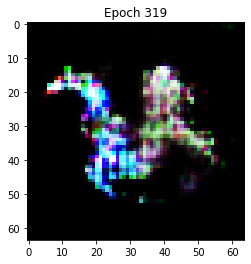

Epoch [320/499]...
d_loss_real:0.606 d_loss_fake:1.931 d_acc_real:0.740 d_acc_fake:0.289
g_loss:0.293 g_acc:0.863
Epoch [321/499]...
d_loss_real:0.255 d_loss_fake:1.865 d_acc_real:0.956 d_acc_fake:0.172
g_loss:0.225 g_acc:0.973
Epoch [322/499]...
d_loss_real:0.522 d_loss_fake:1.462 d_acc_real:0.766 d_acc_fake:0.370
g_loss:0.356 g_acc:0.879
Epoch [323/499]...
d_loss_real:0.316 d_loss_fake:1.536 d_acc_real:0.872 d_acc_fake:0.323
g_loss:0.230 g_acc:0.953
Epoch [324/499]...
d_loss_real:0.351 d_loss_fake:1.921 d_acc_real:0.812 d_acc_fake:0.279
g_loss:0.425 g_acc:0.781
Epoch [325/499]...
d_loss_real:0.267 d_loss_fake:1.522 d_acc_real:0.896 d_acc_fake:0.320
g_loss:0.260 g_acc:0.915
Epoch [326/499]...
d_loss_real:0.322 d_loss_fake:1.738 d_acc_real:0.865 d_acc_fake:0.297
g_loss:0.471 g_acc:0.803
Epoch [327/499]...
d_loss_real:0.390 d_loss_fake:1.558 d_acc_real:0.828 d_acc_fake:0.292
g_loss:0.356 g_acc:0.754
Epoch [328/499]...
d_loss_real:0.290 d_loss_fake:1.933 d_acc_real:0.896 d_acc_fake:0.258

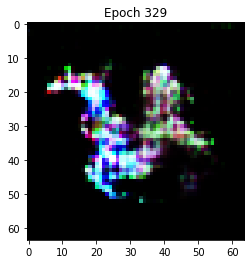

Epoch [330/499]...
d_loss_real:0.332 d_loss_fake:1.552 d_acc_real:0.854 d_acc_fake:0.276
g_loss:0.381 g_acc:0.845
Epoch [331/499]...
d_loss_real:0.334 d_loss_fake:1.652 d_acc_real:0.854 d_acc_fake:0.328
g_loss:0.438 g_acc:0.783
Epoch [332/499]...
d_loss_real:0.220 d_loss_fake:1.440 d_acc_real:0.930 d_acc_fake:0.445
g_loss:0.237 g_acc:0.948
Epoch [333/499]...
d_loss_real:0.230 d_loss_fake:1.556 d_acc_real:0.938 d_acc_fake:0.182
g_loss:0.271 g_acc:0.932
Epoch [334/499]...
d_loss_real:0.326 d_loss_fake:1.403 d_acc_real:0.839 d_acc_fake:0.370
g_loss:0.323 g_acc:0.906
Epoch [335/499]...
d_loss_real:0.457 d_loss_fake:1.549 d_acc_real:0.674 d_acc_fake:0.318
g_loss:0.293 g_acc:0.904
Epoch [336/499]...
d_loss_real:0.222 d_loss_fake:1.783 d_acc_real:0.961 d_acc_fake:0.333
g_loss:0.236 g_acc:0.967
Epoch [337/499]...
d_loss_real:0.376 d_loss_fake:1.293 d_acc_real:0.859 d_acc_fake:0.310
g_loss:0.314 g_acc:0.858
Epoch [338/499]...
d_loss_real:0.413 d_loss_fake:1.558 d_acc_real:0.789 d_acc_fake:0.375

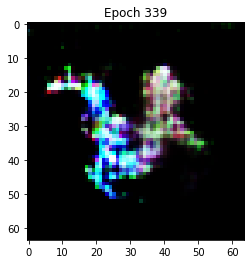

Epoch [340/499]...
d_loss_real:0.274 d_loss_fake:1.578 d_acc_real:0.932 d_acc_fake:0.268
g_loss:0.350 g_acc:0.842
Epoch [341/499]...
d_loss_real:0.298 d_loss_fake:1.507 d_acc_real:0.896 d_acc_fake:0.328
g_loss:0.249 g_acc:0.969
Epoch [342/499]...
d_loss_real:0.276 d_loss_fake:1.300 d_acc_real:0.956 d_acc_fake:0.391
g_loss:0.311 g_acc:0.876
Epoch [343/499]...
d_loss_real:0.381 d_loss_fake:1.587 d_acc_real:0.852 d_acc_fake:0.201
g_loss:0.218 g_acc:0.957
Epoch [344/499]...
d_loss_real:0.493 d_loss_fake:1.469 d_acc_real:0.753 d_acc_fake:0.320
g_loss:0.339 g_acc:0.844
Epoch [345/499]...
d_loss_real:0.558 d_loss_fake:1.551 d_acc_real:0.841 d_acc_fake:0.409
g_loss:0.336 g_acc:0.848
Epoch [346/499]...
d_loss_real:0.210 d_loss_fake:1.640 d_acc_real:0.951 d_acc_fake:0.328
g_loss:0.245 g_acc:0.954
Epoch [347/499]...
d_loss_real:0.223 d_loss_fake:1.311 d_acc_real:0.969 d_acc_fake:0.398
g_loss:0.297 g_acc:0.926
Epoch [348/499]...
d_loss_real:0.355 d_loss_fake:1.446 d_acc_real:0.867 d_acc_fake:0.323

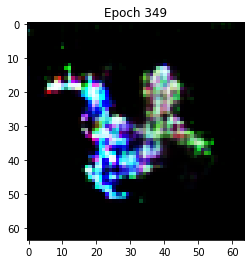

Epoch [350/499]...
d_loss_real:0.247 d_loss_fake:1.642 d_acc_real:0.857 d_acc_fake:0.268
g_loss:0.336 g_acc:0.849
Epoch [351/499]...
d_loss_real:0.580 d_loss_fake:1.708 d_acc_real:0.898 d_acc_fake:0.307
g_loss:0.249 g_acc:0.952
Epoch [352/499]...
d_loss_real:0.403 d_loss_fake:1.557 d_acc_real:0.865 d_acc_fake:0.263
g_loss:0.269 g_acc:0.941
Epoch [353/499]...
d_loss_real:0.359 d_loss_fake:1.407 d_acc_real:0.846 d_acc_fake:0.286
g_loss:0.348 g_acc:0.831
Epoch [354/499]...
d_loss_real:0.270 d_loss_fake:1.544 d_acc_real:0.911 d_acc_fake:0.279
g_loss:0.333 g_acc:0.910
Epoch [355/499]...
d_loss_real:0.436 d_loss_fake:1.758 d_acc_real:0.799 d_acc_fake:0.292
g_loss:0.348 g_acc:0.867
Epoch [356/499]...
d_loss_real:0.188 d_loss_fake:1.835 d_acc_real:0.945 d_acc_fake:0.188
g_loss:0.323 g_acc:0.835
Epoch [357/499]...
d_loss_real:0.738 d_loss_fake:1.247 d_acc_real:0.799 d_acc_fake:0.393
g_loss:0.314 g_acc:0.880
Epoch [358/499]...
d_loss_real:0.287 d_loss_fake:1.845 d_acc_real:0.914 d_acc_fake:0.307

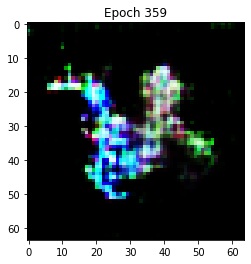

Epoch [360/499]...
d_loss_real:0.330 d_loss_fake:1.549 d_acc_real:0.854 d_acc_fake:0.302
g_loss:0.222 g_acc:0.958
Epoch [361/499]...
d_loss_real:0.416 d_loss_fake:1.551 d_acc_real:0.810 d_acc_fake:0.253
g_loss:0.328 g_acc:0.872
Epoch [362/499]...
d_loss_real:0.390 d_loss_fake:1.528 d_acc_real:0.766 d_acc_fake:0.266
g_loss:0.273 g_acc:0.922
Epoch [363/499]...
d_loss_real:0.292 d_loss_fake:1.489 d_acc_real:0.917 d_acc_fake:0.260
g_loss:0.344 g_acc:0.823
Epoch [364/499]...
d_loss_real:0.361 d_loss_fake:1.657 d_acc_real:0.797 d_acc_fake:0.208
g_loss:0.296 g_acc:0.905
Epoch [365/499]...
d_loss_real:0.347 d_loss_fake:1.450 d_acc_real:0.878 d_acc_fake:0.458
g_loss:0.473 g_acc:0.741
Epoch [366/499]...
d_loss_real:0.314 d_loss_fake:1.900 d_acc_real:0.852 d_acc_fake:0.201
g_loss:0.338 g_acc:0.872
Epoch [367/499]...
d_loss_real:0.227 d_loss_fake:2.090 d_acc_real:0.938 d_acc_fake:0.185
g_loss:0.308 g_acc:0.866
Epoch [368/499]...
d_loss_real:0.466 d_loss_fake:1.599 d_acc_real:0.831 d_acc_fake:0.276

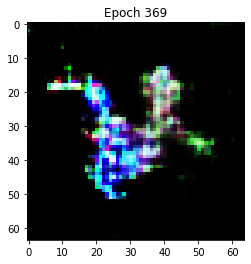

Epoch [370/499]...
d_loss_real:0.470 d_loss_fake:1.643 d_acc_real:0.831 d_acc_fake:0.195
g_loss:0.406 g_acc:0.789
Epoch [371/499]...
d_loss_real:0.190 d_loss_fake:1.768 d_acc_real:0.987 d_acc_fake:0.245
g_loss:0.395 g_acc:0.781
Epoch [372/499]...
d_loss_real:0.342 d_loss_fake:1.671 d_acc_real:0.812 d_acc_fake:0.258
g_loss:0.324 g_acc:0.915
Epoch [373/499]...
d_loss_real:0.241 d_loss_fake:1.999 d_acc_real:0.964 d_acc_fake:0.094
g_loss:0.344 g_acc:0.905
Epoch [374/499]...
d_loss_real:0.401 d_loss_fake:1.501 d_acc_real:0.844 d_acc_fake:0.221
g_loss:0.332 g_acc:0.883
Epoch [375/499]...
d_loss_real:0.347 d_loss_fake:1.667 d_acc_real:0.841 d_acc_fake:0.206
g_loss:0.326 g_acc:0.859
Epoch [376/499]...
d_loss_real:0.292 d_loss_fake:1.640 d_acc_real:0.914 d_acc_fake:0.294
g_loss:0.301 g_acc:0.895
Epoch [377/499]...
d_loss_real:0.340 d_loss_fake:1.480 d_acc_real:0.870 d_acc_fake:0.208
g_loss:0.292 g_acc:0.895
Epoch [378/499]...
d_loss_real:0.283 d_loss_fake:1.370 d_acc_real:0.888 d_acc_fake:0.357

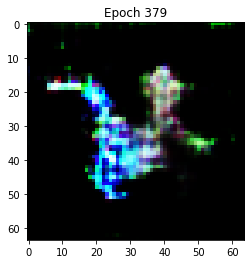

Epoch [380/499]...
d_loss_real:0.238 d_loss_fake:1.716 d_acc_real:0.904 d_acc_fake:0.193
g_loss:0.358 g_acc:0.827
Epoch [381/499]...
d_loss_real:0.252 d_loss_fake:1.719 d_acc_real:0.932 d_acc_fake:0.219
g_loss:0.357 g_acc:0.872
Epoch [382/499]...
d_loss_real:0.375 d_loss_fake:1.658 d_acc_real:0.810 d_acc_fake:0.159
g_loss:0.261 g_acc:0.960
Epoch [383/499]...
d_loss_real:0.381 d_loss_fake:1.607 d_acc_real:0.852 d_acc_fake:0.310
g_loss:0.295 g_acc:0.927
Epoch [384/499]...
d_loss_real:0.331 d_loss_fake:1.716 d_acc_real:0.862 d_acc_fake:0.201
g_loss:0.281 g_acc:0.928
Epoch [385/499]...
d_loss_real:0.257 d_loss_fake:1.430 d_acc_real:0.948 d_acc_fake:0.302
g_loss:0.333 g_acc:0.867
Epoch [386/499]...
d_loss_real:0.280 d_loss_fake:1.473 d_acc_real:0.909 d_acc_fake:0.401
g_loss:0.281 g_acc:0.936
Epoch [387/499]...
d_loss_real:0.379 d_loss_fake:1.726 d_acc_real:0.888 d_acc_fake:0.167
g_loss:0.371 g_acc:0.842
Epoch [388/499]...
d_loss_real:0.347 d_loss_fake:1.365 d_acc_real:0.854 d_acc_fake:0.357

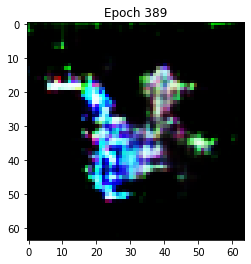

Epoch [390/499]...
d_loss_real:0.298 d_loss_fake:1.683 d_acc_real:0.906 d_acc_fake:0.299
g_loss:0.309 g_acc:0.906
Epoch [391/499]...
d_loss_real:0.408 d_loss_fake:1.507 d_acc_real:0.846 d_acc_fake:0.406
g_loss:0.230 g_acc:0.954
Epoch [392/499]...
d_loss_real:0.262 d_loss_fake:1.783 d_acc_real:0.917 d_acc_fake:0.292
g_loss:0.291 g_acc:0.904
Epoch [393/499]...
d_loss_real:0.454 d_loss_fake:1.657 d_acc_real:0.846 d_acc_fake:0.229
g_loss:0.325 g_acc:0.848
Epoch [394/499]...
d_loss_real:0.262 d_loss_fake:1.636 d_acc_real:0.865 d_acc_fake:0.260
g_loss:0.276 g_acc:0.941
Epoch [395/499]...
d_loss_real:0.260 d_loss_fake:1.633 d_acc_real:0.945 d_acc_fake:0.294
g_loss:0.305 g_acc:0.870
Epoch [396/499]...
d_loss_real:0.418 d_loss_fake:1.686 d_acc_real:0.828 d_acc_fake:0.344
g_loss:0.277 g_acc:0.928
Epoch [397/499]...
d_loss_real:0.394 d_loss_fake:1.704 d_acc_real:0.818 d_acc_fake:0.258
g_loss:0.263 g_acc:0.944
Epoch [398/499]...
d_loss_real:0.501 d_loss_fake:1.725 d_acc_real:0.841 d_acc_fake:0.211

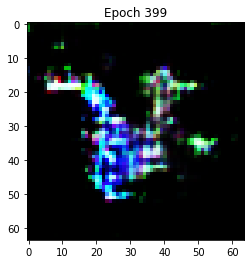

Epoch [400/499]...
d_loss_real:0.260 d_loss_fake:1.526 d_acc_real:0.906 d_acc_fake:0.336
g_loss:0.318 g_acc:0.862
Epoch [401/499]...
d_loss_real:0.236 d_loss_fake:1.658 d_acc_real:0.924 d_acc_fake:0.208
g_loss:0.328 g_acc:0.898
Epoch [402/499]...
d_loss_real:0.324 d_loss_fake:1.589 d_acc_real:0.888 d_acc_fake:0.354
g_loss:0.220 g_acc:0.960
Epoch [403/499]...
d_loss_real:0.385 d_loss_fake:1.746 d_acc_real:0.823 d_acc_fake:0.352
g_loss:0.360 g_acc:0.831
Epoch [404/499]...
d_loss_real:0.326 d_loss_fake:1.827 d_acc_real:0.893 d_acc_fake:0.128
g_loss:0.293 g_acc:0.924
Epoch [405/499]...
d_loss_real:0.679 d_loss_fake:1.199 d_acc_real:0.747 d_acc_fake:0.430
g_loss:0.276 g_acc:0.902
Epoch [406/499]...
d_loss_real:0.434 d_loss_fake:1.775 d_acc_real:0.792 d_acc_fake:0.339
g_loss:0.310 g_acc:0.878
Epoch [407/499]...
d_loss_real:0.271 d_loss_fake:2.044 d_acc_real:0.909 d_acc_fake:0.188
g_loss:0.339 g_acc:0.880
Epoch [408/499]...
d_loss_real:0.312 d_loss_fake:1.645 d_acc_real:0.844 d_acc_fake:0.253

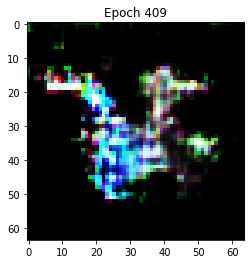

Epoch [410/499]...
d_loss_real:0.312 d_loss_fake:1.435 d_acc_real:0.909 d_acc_fake:0.307
g_loss:0.301 g_acc:0.923
Epoch [411/499]...
d_loss_real:0.404 d_loss_fake:1.622 d_acc_real:0.891 d_acc_fake:0.219
g_loss:0.270 g_acc:0.932
Epoch [412/499]...
d_loss_real:0.286 d_loss_fake:1.597 d_acc_real:0.911 d_acc_fake:0.271
g_loss:0.284 g_acc:0.951
Epoch [413/499]...
d_loss_real:0.273 d_loss_fake:1.492 d_acc_real:0.909 d_acc_fake:0.174
g_loss:0.265 g_acc:0.947
Epoch [414/499]...
d_loss_real:0.513 d_loss_fake:1.573 d_acc_real:0.724 d_acc_fake:0.286
g_loss:0.347 g_acc:0.866
Epoch [415/499]...
d_loss_real:0.349 d_loss_fake:1.434 d_acc_real:0.872 d_acc_fake:0.339
g_loss:0.286 g_acc:0.908
Epoch [416/499]...
d_loss_real:0.327 d_loss_fake:1.634 d_acc_real:0.812 d_acc_fake:0.336
g_loss:0.408 g_acc:0.760
Epoch [417/499]...
d_loss_real:0.200 d_loss_fake:1.896 d_acc_real:0.964 d_acc_fake:0.214
g_loss:0.264 g_acc:0.951
Epoch [418/499]...
d_loss_real:0.403 d_loss_fake:1.650 d_acc_real:0.823 d_acc_fake:0.279

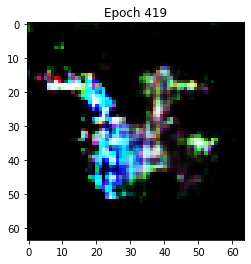

Epoch [420/499]...
d_loss_real:0.317 d_loss_fake:1.544 d_acc_real:0.857 d_acc_fake:0.323
g_loss:0.278 g_acc:0.935
Epoch [421/499]...
d_loss_real:0.306 d_loss_fake:1.634 d_acc_real:0.901 d_acc_fake:0.370
g_loss:0.310 g_acc:0.896
Epoch [422/499]...
d_loss_real:0.227 d_loss_fake:1.584 d_acc_real:0.971 d_acc_fake:0.182
g_loss:0.257 g_acc:0.938
Epoch [423/499]...
d_loss_real:0.300 d_loss_fake:1.516 d_acc_real:0.904 d_acc_fake:0.234
g_loss:0.303 g_acc:0.934
Epoch [424/499]...
d_loss_real:0.402 d_loss_fake:1.666 d_acc_real:0.789 d_acc_fake:0.281
g_loss:0.219 g_acc:0.949
Epoch [425/499]...
d_loss_real:0.402 d_loss_fake:1.689 d_acc_real:0.823 d_acc_fake:0.344
g_loss:0.270 g_acc:0.932
Epoch [426/499]...
d_loss_real:0.474 d_loss_fake:1.502 d_acc_real:0.789 d_acc_fake:0.315
g_loss:0.250 g_acc:0.951
Epoch [427/499]...
d_loss_real:0.402 d_loss_fake:1.546 d_acc_real:0.852 d_acc_fake:0.393
g_loss:0.268 g_acc:0.948
Epoch [428/499]...
d_loss_real:0.145 d_loss_fake:1.785 d_acc_real:0.977 d_acc_fake:0.245

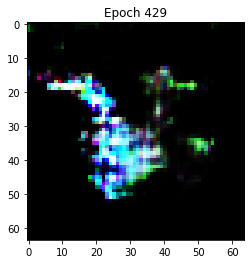

Epoch [430/499]...
d_loss_real:0.184 d_loss_fake:1.658 d_acc_real:0.984 d_acc_fake:0.206
g_loss:0.298 g_acc:0.900
Epoch [431/499]...
d_loss_real:0.265 d_loss_fake:1.772 d_acc_real:0.904 d_acc_fake:0.208
g_loss:0.268 g_acc:0.944
Epoch [432/499]...
d_loss_real:0.431 d_loss_fake:1.332 d_acc_real:0.794 d_acc_fake:0.404
g_loss:0.303 g_acc:0.885
Epoch [433/499]...
d_loss_real:0.232 d_loss_fake:1.874 d_acc_real:0.953 d_acc_fake:0.339
g_loss:0.308 g_acc:0.846
Epoch [434/499]...
d_loss_real:0.370 d_loss_fake:1.719 d_acc_real:0.818 d_acc_fake:0.367
g_loss:0.394 g_acc:0.814
Epoch [435/499]...
d_loss_real:0.232 d_loss_fake:1.980 d_acc_real:0.872 d_acc_fake:0.154
g_loss:0.344 g_acc:0.805
Epoch [436/499]...
d_loss_real:0.251 d_loss_fake:1.696 d_acc_real:0.914 d_acc_fake:0.174
g_loss:0.371 g_acc:0.827
Epoch [437/499]...
d_loss_real:0.254 d_loss_fake:1.754 d_acc_real:0.911 d_acc_fake:0.284
g_loss:0.255 g_acc:0.919
Epoch [438/499]...
d_loss_real:0.301 d_loss_fake:1.698 d_acc_real:0.904 d_acc_fake:0.260

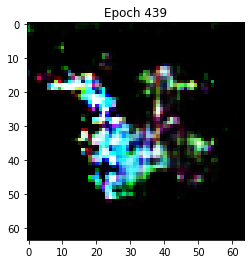

Epoch [440/499]...
d_loss_real:0.392 d_loss_fake:1.991 d_acc_real:0.833 d_acc_fake:0.188
g_loss:0.325 g_acc:0.878
Epoch [441/499]...
d_loss_real:0.444 d_loss_fake:1.773 d_acc_real:0.768 d_acc_fake:0.190
g_loss:0.265 g_acc:0.941
Epoch [442/499]...
d_loss_real:0.410 d_loss_fake:1.719 d_acc_real:0.826 d_acc_fake:0.359
g_loss:0.291 g_acc:0.915
Epoch [443/499]...
d_loss_real:0.233 d_loss_fake:1.828 d_acc_real:0.930 d_acc_fake:0.263
g_loss:0.257 g_acc:0.939
Epoch [444/499]...
d_loss_real:0.290 d_loss_fake:1.396 d_acc_real:0.891 d_acc_fake:0.419
g_loss:0.284 g_acc:0.874
Epoch [445/499]...
d_loss_real:0.218 d_loss_fake:1.802 d_acc_real:0.948 d_acc_fake:0.159
g_loss:0.257 g_acc:0.909
Epoch [446/499]...
d_loss_real:0.380 d_loss_fake:1.509 d_acc_real:0.831 d_acc_fake:0.263
g_loss:0.319 g_acc:0.870
Epoch [447/499]...
d_loss_real:0.264 d_loss_fake:1.629 d_acc_real:0.943 d_acc_fake:0.391
g_loss:0.319 g_acc:0.835
Epoch [448/499]...
d_loss_real:0.218 d_loss_fake:1.700 d_acc_real:0.948 d_acc_fake:0.370

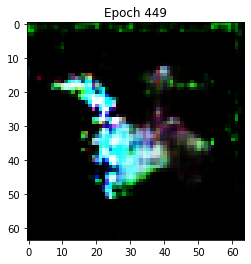

Epoch [450/499]...
d_loss_real:0.302 d_loss_fake:2.364 d_acc_real:0.852 d_acc_fake:0.268
g_loss:0.333 g_acc:0.842
Epoch [451/499]...
d_loss_real:0.264 d_loss_fake:1.896 d_acc_real:0.904 d_acc_fake:0.216
g_loss:0.318 g_acc:0.906
Epoch [452/499]...
d_loss_real:0.364 d_loss_fake:1.656 d_acc_real:0.844 d_acc_fake:0.148
g_loss:0.302 g_acc:0.944
Epoch [453/499]...
d_loss_real:0.269 d_loss_fake:1.695 d_acc_real:0.922 d_acc_fake:0.352
g_loss:0.327 g_acc:0.859
Epoch [454/499]...
d_loss_real:0.313 d_loss_fake:1.831 d_acc_real:0.865 d_acc_fake:0.286
g_loss:0.294 g_acc:0.914
Epoch [455/499]...
d_loss_real:0.337 d_loss_fake:1.772 d_acc_real:0.862 d_acc_fake:0.292
g_loss:0.281 g_acc:0.908
Epoch [456/499]...
d_loss_real:0.341 d_loss_fake:1.710 d_acc_real:0.901 d_acc_fake:0.206
g_loss:0.245 g_acc:0.944
Epoch [457/499]...
d_loss_real:0.366 d_loss_fake:1.771 d_acc_real:0.891 d_acc_fake:0.219
g_loss:0.313 g_acc:0.898
Epoch [458/499]...
d_loss_real:0.419 d_loss_fake:1.500 d_acc_real:0.812 d_acc_fake:0.276

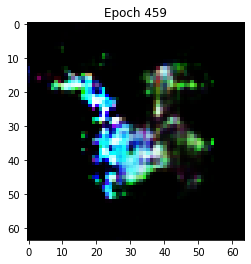

Epoch [460/499]...
d_loss_real:0.215 d_loss_fake:1.892 d_acc_real:0.927 d_acc_fake:0.266
g_loss:0.347 g_acc:0.850
Epoch [461/499]...
d_loss_real:0.328 d_loss_fake:1.775 d_acc_real:0.883 d_acc_fake:0.266
g_loss:0.414 g_acc:0.875
Epoch [462/499]...
d_loss_real:0.295 d_loss_fake:1.687 d_acc_real:0.911 d_acc_fake:0.250
g_loss:0.389 g_acc:0.810
Epoch [463/499]...
d_loss_real:0.305 d_loss_fake:2.023 d_acc_real:0.865 d_acc_fake:0.177
g_loss:0.327 g_acc:0.900
Epoch [464/499]...
d_loss_real:0.341 d_loss_fake:2.010 d_acc_real:0.857 d_acc_fake:0.203
g_loss:0.295 g_acc:0.919
Epoch [465/499]...
d_loss_real:0.278 d_loss_fake:1.603 d_acc_real:0.945 d_acc_fake:0.281
g_loss:0.349 g_acc:0.893
Epoch [466/499]...
d_loss_real:0.230 d_loss_fake:1.592 d_acc_real:0.935 d_acc_fake:0.229
g_loss:0.342 g_acc:0.891
Epoch [467/499]...
d_loss_real:0.290 d_loss_fake:1.795 d_acc_real:0.893 d_acc_fake:0.349
g_loss:0.377 g_acc:0.822
Epoch [468/499]...
d_loss_real:0.271 d_loss_fake:1.773 d_acc_real:0.909 d_acc_fake:0.177

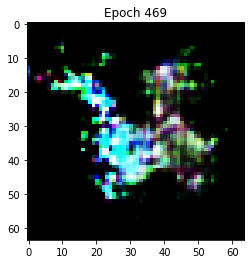

Epoch [470/499]...
d_loss_real:0.199 d_loss_fake:1.680 d_acc_real:0.966 d_acc_fake:0.341
g_loss:0.210 g_acc:0.974
Epoch [471/499]...
d_loss_real:0.454 d_loss_fake:1.694 d_acc_real:0.763 d_acc_fake:0.141
g_loss:0.289 g_acc:0.910
Epoch [472/499]...
d_loss_real:0.351 d_loss_fake:1.328 d_acc_real:0.859 d_acc_fake:0.349
g_loss:0.402 g_acc:0.797
Epoch [473/499]...
d_loss_real:0.194 d_loss_fake:1.544 d_acc_real:0.927 d_acc_fake:0.354
g_loss:0.433 g_acc:0.750
Epoch [474/499]...
d_loss_real:0.280 d_loss_fake:2.158 d_acc_real:0.888 d_acc_fake:0.182
g_loss:0.282 g_acc:0.908
Epoch [475/499]...
d_loss_real:0.189 d_loss_fake:1.424 d_acc_real:0.982 d_acc_fake:0.263
g_loss:0.232 g_acc:0.961
Epoch [476/499]...
d_loss_real:0.393 d_loss_fake:1.161 d_acc_real:0.893 d_acc_fake:0.346
g_loss:0.251 g_acc:0.965
Epoch [477/499]...
d_loss_real:0.385 d_loss_fake:1.629 d_acc_real:0.862 d_acc_fake:0.240
g_loss:0.262 g_acc:0.931
Epoch [478/499]...
d_loss_real:0.654 d_loss_fake:1.485 d_acc_real:0.771 d_acc_fake:0.315

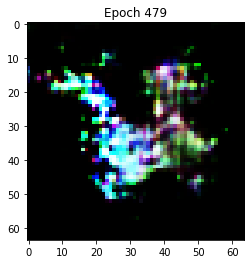

Epoch [480/499]...
d_loss_real:0.421 d_loss_fake:1.797 d_acc_real:0.773 d_acc_fake:0.172
g_loss:0.318 g_acc:0.887
Epoch [481/499]...
d_loss_real:0.343 d_loss_fake:1.875 d_acc_real:0.862 d_acc_fake:0.255
g_loss:0.390 g_acc:0.806
Epoch [482/499]...
d_loss_real:0.366 d_loss_fake:1.850 d_acc_real:0.846 d_acc_fake:0.221
g_loss:0.357 g_acc:0.876
Epoch [483/499]...
d_loss_real:0.207 d_loss_fake:1.565 d_acc_real:0.977 d_acc_fake:0.362
g_loss:0.258 g_acc:0.953
Epoch [484/499]...
d_loss_real:0.262 d_loss_fake:1.810 d_acc_real:0.940 d_acc_fake:0.221
g_loss:0.393 g_acc:0.874
Epoch [485/499]...
d_loss_real:0.234 d_loss_fake:1.593 d_acc_real:0.964 d_acc_fake:0.286
g_loss:0.361 g_acc:0.814
Epoch [486/499]...
d_loss_real:0.294 d_loss_fake:1.639 d_acc_real:0.859 d_acc_fake:0.297
g_loss:0.372 g_acc:0.833
Epoch [487/499]...
d_loss_real:0.161 d_loss_fake:1.388 d_acc_real:0.974 d_acc_fake:0.328
g_loss:0.302 g_acc:0.859
Epoch [488/499]...
d_loss_real:0.254 d_loss_fake:2.233 d_acc_real:0.911 d_acc_fake:0.096

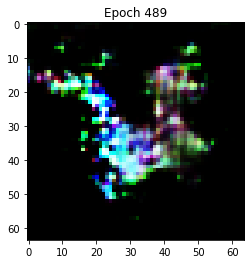

Epoch [490/499]...
d_loss_real:0.251 d_loss_fake:1.932 d_acc_real:0.948 d_acc_fake:0.130
g_loss:0.249 g_acc:0.957
Epoch [491/499]...
d_loss_real:0.452 d_loss_fake:1.357 d_acc_real:0.781 d_acc_fake:0.393
g_loss:0.463 g_acc:0.822
Epoch [492/499]...
d_loss_real:0.185 d_loss_fake:1.459 d_acc_real:0.922 d_acc_fake:0.315
g_loss:0.353 g_acc:0.820
Epoch [493/499]...
d_loss_real:0.331 d_loss_fake:2.153 d_acc_real:0.820 d_acc_fake:0.234
g_loss:0.320 g_acc:0.895
Epoch [494/499]...
d_loss_real:0.246 d_loss_fake:1.793 d_acc_real:0.919 d_acc_fake:0.094
g_loss:0.298 g_acc:0.900
Epoch [495/499]...
d_loss_real:0.266 d_loss_fake:1.236 d_acc_real:0.924 d_acc_fake:0.479
g_loss:0.225 g_acc:0.961
Epoch [496/499]...
d_loss_real:0.319 d_loss_fake:1.727 d_acc_real:0.930 d_acc_fake:0.328
g_loss:0.339 g_acc:0.844
Epoch [497/499]...
d_loss_real:0.198 d_loss_fake:1.714 d_acc_real:0.979 d_acc_fake:0.214
g_loss:0.389 g_acc:0.841
Epoch [498/499]...
d_loss_real:0.323 d_loss_fake:1.752 d_acc_real:0.841 d_acc_fake:0.198

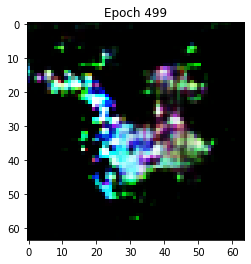

In [419]:
epochs = 500
batch_size = 32
#history = {'d_loss_real':[],'d_loss_fake':[],'d_acc_real':[],'d_acc_fake':[], 'g_loss':[],'g_acc':[]}
#history = {'d_loss':[],'d_acc':[], 'g_loss':[],'g_acc':[]}

noise = np.random.normal(0,1, 100)
num_batches = int(len(X) // batch_size)


for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs-1}]...')
    np.random.seed(epoch)
    np.random.shuffle(X)

    d_metrics = train_discriminator(X, batch_size, num_batches)
    history['d_loss_real'].append(d_metrics[0][0])
    history['d_loss_fake'].append(d_metrics[1][0])
    history['d_acc_real'].append(d_metrics[0][1])
    history['d_acc_fake'].append(d_metrics[1][1])
    g_metrics =  train_generator(batch_size, num_batches)
#     history['d_loss'].append(d_metrics[0])
#     history['d_acc'].append(d_metrics[1])
    history['g_loss'].append(g_metrics[0])
    history['g_acc'].append(g_metrics[1])
    
    print(f'd_loss_real:{d_metrics[0][0]:.3f} d_loss_fake:{d_metrics[1][0]:.3f} d_acc_real:{d_metrics[0][1]:.3f} d_acc_fake:{d_metrics[1][1]:.3f}')
    #print(f'd_loss:{d_metrics[0]:.3f} d_acc:{d_metrics[1]:.3f}')
    print(f'g_loss:{g_metrics[0]:.3f} g_acc:{g_metrics[1]:.3f}')
    if epoch % 10 == 9 or epoch == 1:
        plt.imshow(unnormalize_tanh(generator.predict(np.array([noise]))[0]))
        plt.title(f'Epoch {epoch}')
        plt.show()
        

11

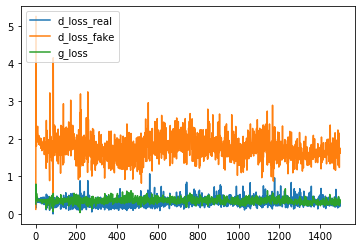

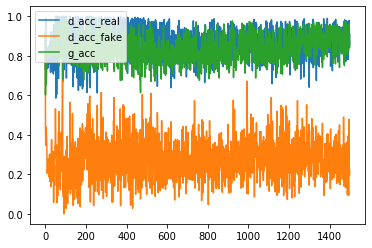

In [422]:
for key in history:
    if 'acc' in key:
        continue
    plt.plot(history[key], label=key)
    plt.legend(loc="upper left")
    
plt.show()
for key in history:
    if 'loss' in key:
        continue
    plt.plot(history[key], label=key)
    plt.legend(loc="upper left")
plt.show()

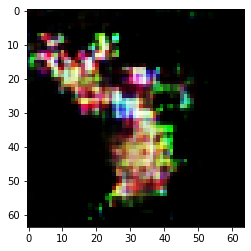

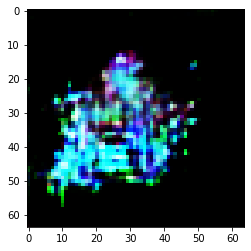

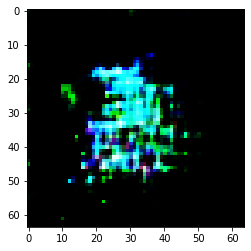

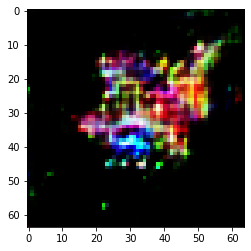

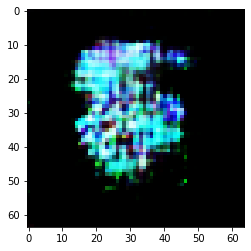

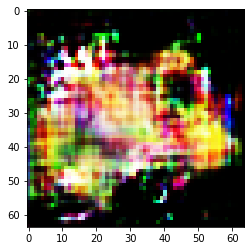

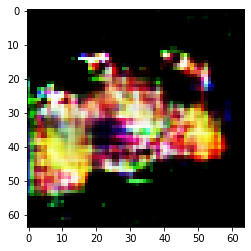

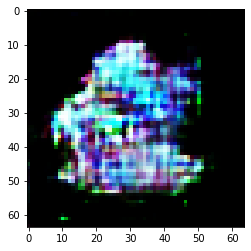

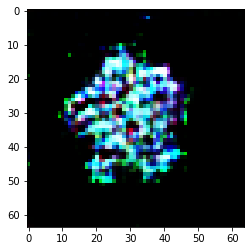

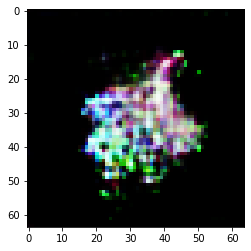

In [423]:
for i in range(10):
    noise = np.random.normal(0,1, 100)
    plt.imshow(unnormalize_tanh(generator.predict(np.array([noise]))[0]))
    plt.show()